# <center>German apartment listings</center>

## 0) Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from timeit import default_timer as timer

import glob
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import dataprocessing as dproc

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

## 1) Data Preprocessing

#### find dates:

In [2]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### load data:

In [3]:
rent_df = dproc.create_rent_df(dates[-1])
sale_df = dproc.create_sale_df(dates[-1])

<IPython.core.display.Javascript object>

#### add links:

In [4]:
rent_df["link"] = "https://www.immobilienscout24.de/expose/" + rent_df[
    "scoutId"
].astype(str)
sale_df["link"] = "https://www.immobilienscout24.de/expose/" + sale_df[
    "scoutId"
].astype(str)

<IPython.core.display.Javascript object>

#### select features:

In [5]:
rent_columns = [
    "rent_m2",
    "baseRent",
    "livingSpace",
    "noRooms",
    "zipCode",
    "regio2",
    "link",
]
rent_df = rent_df[rent_columns].copy()

sale_columns = [
    "price_m2",
    "purchasePrice",
    "livingSpace",
    "noRooms",
    "zipCode",
    "regio2",
    "link",
]
sale_df = sale_df[sale_columns].copy()

<IPython.core.display.Javascript object>

#### add return of investment based on median rents for zipCode

In [6]:
g = rent_df.groupby("zipCode")["rent_m2"].median()
g.name = "rent_m2_zC"
rent_m2_zipCode = sale_df.join(g, on="zipCode").copy()["rent_m2_zC"]
sale_df.insert(
    loc=sale_df.columns.get_loc("zipCode") + 1,
    column="rent_m2_zC",
    value=rent_m2_zipCode,
)

yearly_ROI = sale_df["rent_m2_zC"] * 12 / sale_df["price_m2"]
sale_df.insert(loc=0, column="yearly_roi", value=yearly_ROI)

<IPython.core.display.Javascript object>

#### remove nans, infs and zeros:

In [7]:
allowed_nan_percentage_cols = 1

rent_df = dproc.remove_nan_inf(rent_df, allowed_nan_percentage_cols)
sale_df = dproc.remove_nan_inf(sale_df, allowed_nan_percentage_cols)

rent_df = rent_df[(rent_df["baseRent"] != 0)]
sale_df = sale_df[(sale_df["purchasePrice"] != 0)]

<IPython.core.display.Javascript object>

#### add combined dataframe with median rents and prices:

In [8]:
group = "zipCode"

combined_df = pd.concat(
    [
        rent_df.groupby(group)["rent_m2"].median(),
        rent_df.groupby(group)["rent_m2"].size(),
        sale_df.groupby(group)["price_m2"].median(),
        sale_df.groupby(group)["price_m2"].size(),
        sale_df.groupby(group)["yearly_roi"].median(),
    ],
    axis=1,
    keys=[
        "median_rent_m2",
        "num_rent",
        "median_price_m2",
        "num_sale",
        "median_yearly_roi",
    ],
).copy()

combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df = combined_df.dropna()

<IPython.core.display.Javascript object>

## 2) Outlier detection apartments for sale

### 2.1) Normalize the data

#### Distribution of living space and prices:

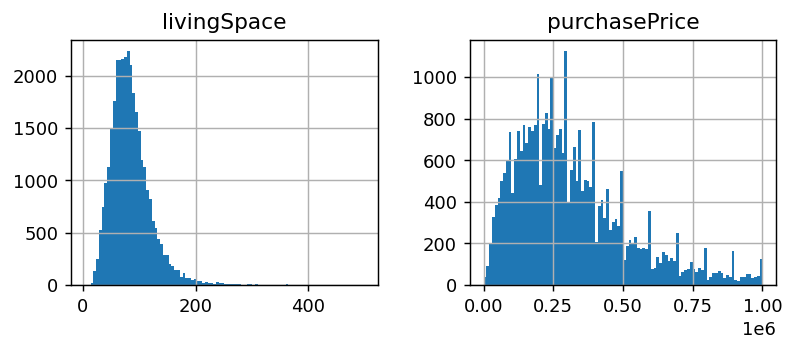

<IPython.core.display.Javascript object>

In [9]:
sale_df[["livingSpace", "purchasePrice"]][
    (sale_df["purchasePrice"] < 1e6) & (sale_df["livingSpace"] < 500)
].hist(bins=100, figsize=(7, 2.5))
pass

#### Boxcox transformation:

Boxcox parameters
livingSpace: lambda = -0.12
purchasePrice: lambda = 0.08


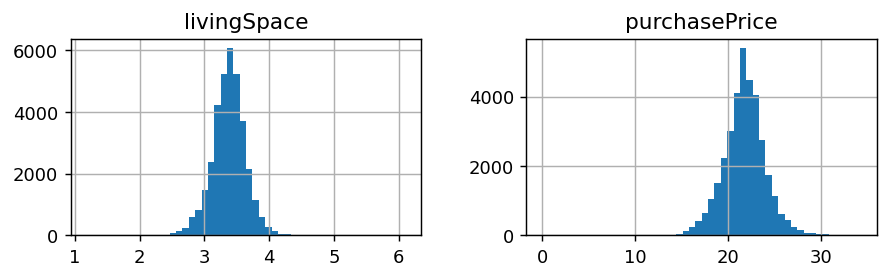

<IPython.core.display.Javascript object>

In [10]:
x_space, lambda_space = stats.boxcox(sale_df["livingSpace"])
x_price, lambda_price = stats.boxcox(sale_df["purchasePrice"])
X_sale = pd.DataFrame({"livingSpace": x_space, "purchasePrice": x_price})
X_sale.hist(bins=50, figsize=(8, 2))
print(
    f"Boxcox parameters\nlivingSpace: lambda = {lambda_space:.2f}\npurchasePrice: lambda = {lambda_price:.2f}"
)

#### Assumed ratio of outliers:

In [11]:
contamination = 0.005

<IPython.core.display.Javascript object>

### 2.2) Gaussian Elliptic Envelope

In [12]:
start = timer()

sale_outlier = EllipticEnvelope(
    contamination=contamination, random_state=42
).fit_predict(X_sale)
sale_inlier_df = sale_df[(sale_outlier == 1)]
sale_outlier_df = sale_df[(sale_outlier == -1)]

end = timer()
print(f"Elapsed time: {np.round(end - start,2)}s")

Elapsed time: 9.06s


<IPython.core.display.Javascript object>

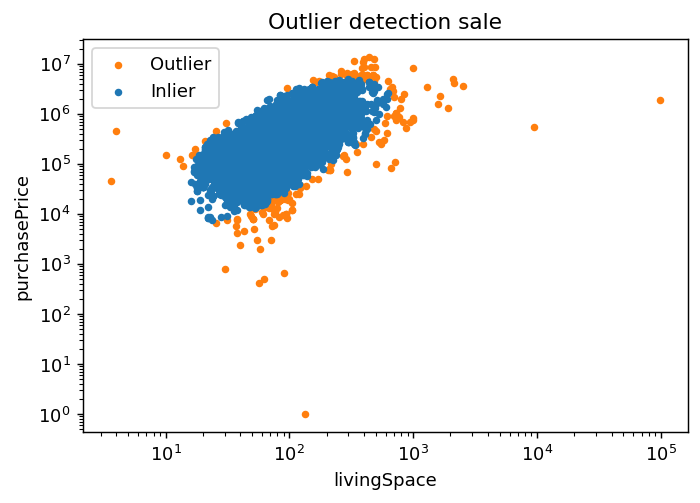

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plt.subplots()
sale_outlier_df.plot.scatter(
    x="livingSpace",
    y="purchasePrice",
    loglog=True,
    title="Outlier detection sale",
    color="C1",
    label="Outlier",
    s=10,
    ax=ax,
)
sale_inlier_df.plot.scatter(
    x="livingSpace", y="purchasePrice", color="C0", label="Inlier", s=10, ax=ax
)
fig.savefig("sale_outlier.png")

## 3) Finding foreclosures with clustering - to be implemented

https://scikit-learn.org/stable/modules/clustering.html

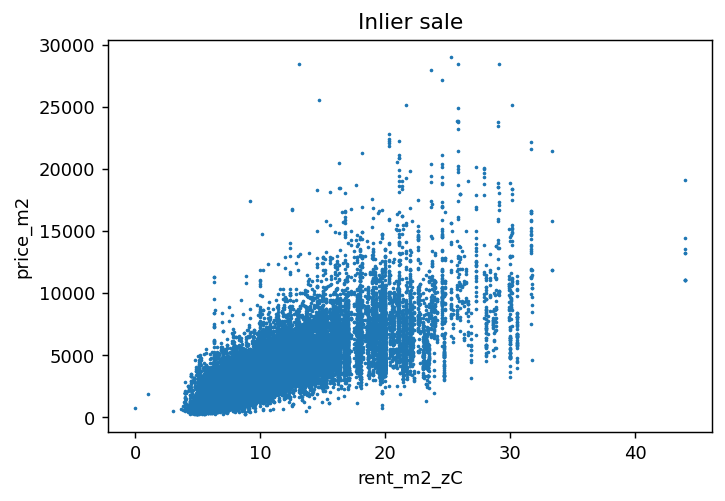

<IPython.core.display.Javascript object>

In [14]:
sale_inlier_df.plot.scatter(
    x="rent_m2_zC", y="price_m2", title="Inlier sale", loglog=False, s=1
)
pass

## 4) Results

### 4.1) Best roi nationally

#### Outlier:

In [15]:
df_show = sale_outlier_df.sort_values("yearly_roi", ascending=False).head(5)
df_show.style.format({"link": dproc.make_clickable})

,yearly_roi,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
30571,13651.61,0.01,1.00,133.00,3.00,27793,8.55,Oldenburg_Kreis,https://www.immobilienscout24.de/expose/116978696
31318,10.44,7.98,500.00,62.66,3.00,31698,6.94,Schaumburg_Kreis,https://www.immobilienscout24.de/expose/116556571
23273,10.02,7.40,423.00,57.19,3.00,99834,6.17,Wartburgkreis,https://www.immobilienscout24.de/expose/120477893
23284,10.01,7.40,667.00,90.16,4.00,99834,6.17,Wartburgkreis,https://www.immobilienscout24.de/expose/120477915
35505,4.07,26.67,800.00,30.00,1.00,49152,9.03,Osnabrück_Kreis,https://www.immobilienscout24.de/expose/105011041


<IPython.core.display.Javascript object>

#### Inlier:

In [16]:
df_show = sale_inlier_df.sort_values("yearly_roi", ascending=False).head(5)
df_show.style.format({"link": dproc.make_clickable})

,yearly_roi,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
21766,0.42,247.34,13000.00,52.56,3.00,25813,8.74,Nordfriesland_Kreis,https://www.immobilienscout24.de/expose/120678823
21768,0.40,262.32,14000.00,53.37,3.00,25813,8.74,Nordfriesland_Kreis,https://www.immobilienscout24.de/expose/120678825
21763,0.40,264.75,14000.00,52.88,3.00,25813,8.74,Nordfriesland_Kreis,https://www.immobilienscout24.de/expose/120678826
15238,0.31,752.65,44000.00,58.46,3.00,15295,19.71,Oder_Spree_Kreis,https://www.immobilienscout24.de/expose/120190369
21680,0.31,272.73,18000.00,66.00,3.00,42107,7.00,Wuppertal,https://www.immobilienscout24.de/expose/120678934


<IPython.core.display.Javascript object>

### 4.2) Apartments by region

#### regions overview:

In [17]:
min_num = 3

combined_filt = (combined_df["num_rent"] > min_num) & (
    combined_df["num_sale"] > min_num
)
combined_df[combined_filt].sort_values("median_yearly_roi", ascending=False)

,median_rent_m2,num_rent,median_price_m2,num_sale,median_yearly_roi
zipCode,,,,,
99834,6.17,5.0,302.81,4.0,5.07
47169,6.10,61.0,278.90,18.0,0.28
2827,4.90,58.0,318.97,6.0,0.18
93449,5.84,4.0,386.36,5.0,0.18
38700,6.36,16.0,546.30,22.0,0.14
...,...,...,...,...,...
83700,16.74,7.0,12610.52,24.0,0.02
80333,25.82,46.0,19894.20,20.0,0.02
7589,5.06,8.0,3968.10,11.0,0.02


<IPython.core.display.Javascript object>

#### select regions to further inspect:

In [18]:
regiontype = "zipCode"
regions = [47229]
combined_df.loc[regions]

,median_rent_m2,num_rent,median_price_m2,num_sale,median_yearly_roi
zipCode,,,,,
47229,6.61,28.0,570.55,10.0,0.14


<IPython.core.display.Javascript object>

### 4.3) Apartments for rent

In [19]:
rent_filt = rent_df[regiontype].isin(regions)
df_show = rent_df[rent_filt].sort_values("rent_m2")

df_show.style.format({"link": dproc.make_clickable})

,rent_m2,baseRent,livingSpace,noRooms,zipCode,regio2,link
78939,3.88,349.00,90.00,1.00,47229,Duisburg,https://www.immobilienscout24.de/expose/116138687
83732,5.14,334.00,65.00,3.00,47229,Duisburg,https://www.immobilienscout24.de/expose/114637869
41912,5.36,337.00,62.84,2.00,47229,Duisburg,https://www.immobilienscout24.de/expose/120598052
44699,5.41,265.03,49.00,2.00,47229,Duisburg,https://www.immobilienscout24.de/expose/120524825
96088,5.43,250.00,46.00,2.00,47229,Duisburg,https://www.immobilienscout24.de/expose/87751423
77078,5.56,344.00,61.87,3.00,47229,Duisburg,https://www.immobilienscout24.de/expose/116647404
38675,5.62,450.00,80.00,3.00,47229,Duisburg,https://www.immobilienscout24.de/expose/64750017
94781,5.65,355.00,62.85,2.00,47229,Duisburg,https://www.immobilienscout24.de/expose/93276843
71842,6.00,372.00,62.00,2.00,47229,Duisburg,https://www.immobilienscout24.de/expose/117864121
60152,6.00,372.00,62.00,2.00,47229,Duisburg,https://www.immobilienscout24.de/expose/119712843


<IPython.core.display.Javascript object>

### 4.4) Apartments for sale

In [20]:
sale_filt = sale_df[regiontype].isin(regions)
df_show = sale_df[sale_filt].sort_values("yearly_roi", ascending=False)

df_show.style.format({"link": dproc.make_clickable})

,yearly_roi,price_m2,purchasePrice,livingSpace,noRooms,zipCode,rent_m2_zC,regio2,link
21883,0.17,461.76,15700.00,34.00,1.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120678613
21873,0.17,480.00,19200.00,40.00,2.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120678612
3293,0.15,540.32,33500.00,62.00,3.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/114795926
21900,0.15,540.32,33500.00,62.00,3.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120678563
21878,0.14,564.18,37800.00,67.00,2.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120678610
21887,0.14,576.92,45000.00,78.00,3.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120678609
6646,0.12,678.95,1290000.00,1900.00,8.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/115312215
6275,0.07,1078.31,89500.00,83.00,3.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/102054871
23190,0.05,1444.44,65000.00,45.00,2.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120485244
7005,0.02,3247.50,1299000.00,400.00,8.00,47229,6.61,Duisburg,https://www.immobilienscout24.de/expose/120198673


<IPython.core.display.Javascript object>